In [2]:
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)

print(keras.__version__)

from numpy.random import seed
seed(123)


2.11.0
2.11.0


# Zad
Porównaj wyniki działań różnych optymalizacji


In [3]:
# Wczytaj dane treningowe i testowe
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

train_set = pd.read_csv('adult.data', sep=", ",header = None)
test_set = pd.read_csv('adult.test', sep=", ",skiprows = 1, header = None) # Make sure to skip a row for the test set

col_labels = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 
              'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
             'wage_class']
train_set.columns = col_labels
test_set.columns = col_labels

train = train_set.replace('?', np.nan).dropna()
test = test_set.replace('?', np.nan).dropna()

train_set.head()


/var/folders/zy/jl2rn8kj7cx0g35_dvq0zksh0000gn/T/ipykernel_45190/1127659990.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  train_set = pd.read_csv('adult.data', sep=", ",header = None)
/var/folders/zy/jl2rn8kj7cx0g35_dvq0zksh0000gn/T/ipykernel_45190/1127659990.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  test_set = pd.read_csv('adult.test', sep=", ",skiprows = 1, header = None) # Make sure to skip a row for the test set


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [4]:
dataset = pd.concat([train,test])

dataset['wage_class'] = dataset.wage_class.replace({'<=50K.': 0,'<=50K':0, '>50K.':1, '>50K':1})

dataset.drop(["fnlwgt"],axis=1,inplace=True)

dataset.drop(["education"],axis=1,inplace=True)

x = dataset.groupby('native_country')["wage_class"].mean()

d = dict(pd.cut(x[x.index!=" United-States"],5,labels=range(5)))

dataset['native_country'] = dataset['native_country'].replace(d)

dataset = pd.get_dummies(dataset,drop_first=True)

train = dataset.iloc[:train.shape[0]]
test = dataset.iloc[train.shape[0]:]

X_train = train.drop("wage_class",axis=1)
y_train = train.wage_class

X_test = test.drop("wage_class",axis=1)
y_test = test.wage_class

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

print(X_train.shape)
X_test.shape


X_test = np.asarray(X_test).astype('float32')
y_test = np.asarray(y_test).astype('float32')
X_train = np.asarray(X_train).astype('float32')
y_train = np.asarray(y_train).astype('float32')

(30162, 41)


# SGD

In [5]:
from keras.models import Sequential
from keras.layers import Dense

from keras.callbacks import History

history_sgd = History()
model = Sequential()
model.add(Dense(100,activation="sigmoid",input_shape=(X_train.shape[1],)))
model.add(Dense(50,activation="sigmoid"))
model.add(Dense(10,activation="sigmoid"))
model.add(Dense(1,activation="sigmoid"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               4200      
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dense_2 (Dense)             (None, 10)                510       
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 9,771
Trainable params: 9,771
Non-trainable params: 0
_________________________________________________________________


2023-06-11 22:12:26.855015: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
sgd = keras.optimizers.legacy.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss="binary_crossentropy",optimizer=sgd, metrics=["accuracy"])

/Users/maja/opt/anaconda3/envs/tf/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [7]:
model.fit(X_train, y_train, validation_data= (X_test, y_test), batch_size=32,epochs=100, callbacks=[history_sgd])

Epoch 1/100
943/943 [==============================] - 1s 997us/step - loss: 0.5401 - accuracy: 0.7500 - val_loss: 0.4493 - val_accuracy: 0.7548
Epoch 2/100
943/943 [==============================] - 1s 871us/step - loss: 0.3653 - accuracy: 0.8280 - val_loss: 0.3425 - val_accuracy: 0.8386
Epoch 3/100
943/943 [==============================] - 1s 875us/step - loss: 0.3386 - accuracy: 0.8406 - val_loss: 0.3353 - val_accuracy: 0.8430
Epoch 4/100
943/943 [==============================] - 1s 866us/step - loss: 0.3328 - accuracy: 0.8438 - val_loss: 0.3308 - val_accuracy: 0.8448
Epoch 5/100
943/943 [==============================] - 1s 865us/step - loss: 0.3306 - accuracy: 0.8429 - val_loss: 0.3292 - val_accuracy: 0.8458
Epoch 6/100
943/943 [==============================] - 1s 878us/step - loss: 0.3284 - accuracy: 0.8468 - val_loss: 0.3278 - val_accuracy: 0.8455
Epoch 7/100
943/943 [==============================] - 1s 864us/step - loss: 0.3273 - accuracy: 0.8461 - val_loss: 0.3282 - val_ac

In [8]:
history_sgd.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

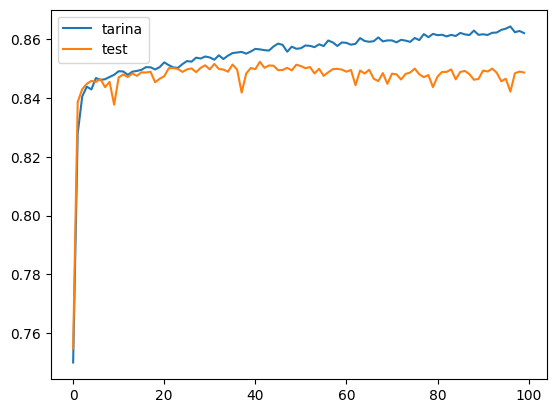

In [9]:
import matplotlib.pyplot as pl
plt.plot(history_sgd.history['accuracy'], label = "tarina")
plt.plot(history_sgd.history['val_accuracy'], label = "test")
plt.legend()
plt.show()

# Zad

Użyjmy LearningRateScheduler

In [10]:
from keras.callbacks import LearningRateScheduler
# learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.01
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * np.power(drop, np.floor((1+epoch)/epochs_drop))
    return lrate

history_lr_1 = History()
model = Sequential()
model.add(Dense(100,activation="sigmoid",input_shape=(X_train.shape[1],)))
model.add(Dense(50,activation="sigmoid"))
model.add(Dense(10,activation="sigmoid"))
model.add(Dense(1,activation="sigmoid"))
model.summary()

# sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss="binary_crossentropy",optimizer="SGD", metrics=["accuracy"])

lrate = LearningRateScheduler(step_decay)
model.fit(X_train, y_train, validation_data= (X_test, y_test), batch_size=32,epochs=100, callbacks=[lrate, history_lr_1])


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 100)               4200      
                                                                 
 dense_5 (Dense)             (None, 50)                5050      
                                                                 
 dense_6 (Dense)             (None, 10)                510       
                                                                 
 dense_7 (Dense)             (None, 1)                 11        
                                                                 
Total params: 9,771
Trainable params: 9,771
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
943/943 [==============================] - 1s 979us/step - loss: 0.5603 - accuracy: 0.7511 - val_loss: 0.5543 - val_accuracy: 0.7543 - lr: 0.0100
Epoch 2/100
943/943 [=====

943/943 [==============================] - 1s 877us/step - loss: 0.3390 - accuracy: 0.8399 - val_loss: 0.3404 - val_accuracy: 0.8396 - lr: 1.9531e-05
Epoch 97/100
943/943 [==============================] - 1s 867us/step - loss: 0.3390 - accuracy: 0.8400 - val_loss: 0.3404 - val_accuracy: 0.8396 - lr: 1.9531e-05
Epoch 98/100
943/943 [==============================] - 1s 867us/step - loss: 0.3390 - accuracy: 0.8399 - val_loss: 0.3404 - val_accuracy: 0.8396 - lr: 1.9531e-05
Epoch 99/100
943/943 [==============================] - 1s 876us/step - loss: 0.3390 - accuracy: 0.8399 - val_loss: 0.3404 - val_accuracy: 0.8396 - lr: 1.9531e-05
Epoch 100/100
943/943 [==============================] - 1s 2ms/step - loss: 0.3390 - accuracy: 0.8399 - val_loss: 0.3404 - val_accuracy: 0.8396 - lr: 9.7656e-06


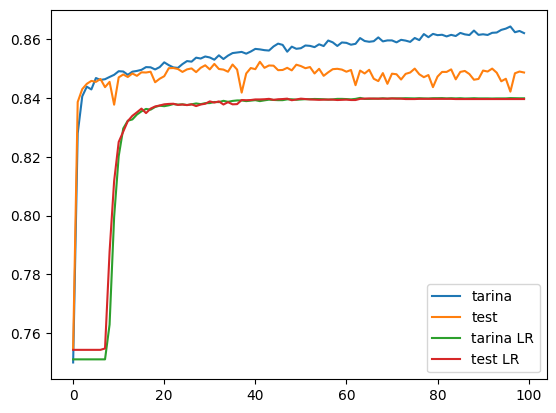

In [11]:
import matplotlib.pyplot as pl
plt.plot(history_sgd.history['accuracy'], label = "tarina")
plt.plot(history_sgd.history['val_accuracy'], label = "test")

plt.plot(history_lr_1.history['accuracy'], label = "tarina LR")
plt.plot(history_lr_1.history['val_accuracy'], label = "test LR")
plt.legend()
plt.show()

# Zad

Wykonaj analogiczne zadanie dla 
* Adam bez LearningRateScheduler i learning_rate=0.001
* Adam z użyciem LearningRateScheduler i learning_rate=0.001
* Adam z użyciem LearningRateScheduler i learning_rate=0.0001

Zwizualizuj wyniki:

* porównaj krzywe uczenia

# Adam

In [12]:
history_adam = History()
model = Sequential()
model.add(Dense(100,activation="sigmoid",input_shape=(X_train.shape[1],)))
model.add(Dense(50,activation="sigmoid"))
model.add(Dense(10,activation="sigmoid"))
model.add(Dense(1,activation="sigmoid"))
model.summary()

Adam = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss="binary_crossentropy",optimizer=Adam, metrics=["accuracy"])

# lrate = LearningRateScheduler(step_decay)
model.fit(X_train, y_train, validation_data= (X_test, y_test), batch_size=32,epochs=100, callbacks=[ history_adam])


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 100)               4200      
                                                                 
 dense_9 (Dense)             (None, 50)                5050      
                                                                 
 dense_10 (Dense)            (None, 10)                510       
                                                                 
 dense_11 (Dense)            (None, 1)                 11        
                                                                 
Total params: 9,771
Trainable params: 9,771
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
943/943 [==============================] - 1s 1ms/step - loss: 0.3819 - accuracy: 0.8252 - val_loss: 0.3490 - val_accuracy: 0.8323
Epoch 2/100
943/943 [====================

Epoch 51/100
943/943 [==============================] - 1s 923us/step - loss: 0.2763 - accuracy: 0.8697 - val_loss: 0.3354 - val_accuracy: 0.8483
Epoch 52/100
943/943 [==============================] - 1s 922us/step - loss: 0.2755 - accuracy: 0.8696 - val_loss: 0.3379 - val_accuracy: 0.8501
Epoch 53/100
943/943 [==============================] - 1s 921us/step - loss: 0.2750 - accuracy: 0.8703 - val_loss: 0.3364 - val_accuracy: 0.8505
Epoch 54/100
943/943 [==============================] - 1s 928us/step - loss: 0.2743 - accuracy: 0.8693 - val_loss: 0.3388 - val_accuracy: 0.8505
Epoch 55/100
943/943 [==============================] - 1s 923us/step - loss: 0.2734 - accuracy: 0.8703 - val_loss: 0.3405 - val_accuracy: 0.8492
Epoch 56/100
943/943 [==============================] - 1s 923us/step - loss: 0.2724 - accuracy: 0.8715 - val_loss: 0.3372 - val_accuracy: 0.8483
Epoch 57/100
943/943 [==============================] - 1s 930us/step - loss: 0.2718 - accuracy: 0.8709 - val_loss: 0.3432 -

In [13]:
history_adam_lr_1 = History()
model = Sequential()
model.add(Dense(100,activation="sigmoid",input_shape=(X_train.shape[1],)))
model.add(Dense(50,activation="sigmoid"))
model.add(Dense(10,activation="sigmoid"))
model.add(Dense(1,activation="sigmoid"))
model.summary()

Adam = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss="binary_crossentropy",optimizer=Adam, metrics=["accuracy"])

lrate = LearningRateScheduler(step_decay)
model.fit(X_train, y_train, validation_data= (X_test, y_test), batch_size=32,epochs=100, callbacks=[lrate, history_adam_lr_1])


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 100)               4200      
                                                                 
 dense_13 (Dense)            (None, 50)                5050      
                                                                 
 dense_14 (Dense)            (None, 10)                510       
                                                                 
 dense_15 (Dense)            (None, 1)                 11        
                                                                 
Total params: 9,771
Trainable params: 9,771
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
943/943 [==============================] - 1s 1ms/step - loss: 0.3484 - accuracy: 0.8366 - val_loss: 0.3276 - val_accuracy: 0.8466 - lr: 0.0100
Epoch 2/100
943/943 [=======

943/943 [==============================] - 1s 946us/step - loss: 0.2092 - accuracy: 0.9010 - val_loss: 0.4317 - val_accuracy: 0.8380 - lr: 1.9531e-05
Epoch 97/100
943/943 [==============================] - 1s 954us/step - loss: 0.2092 - accuracy: 0.9009 - val_loss: 0.4319 - val_accuracy: 0.8379 - lr: 1.9531e-05
Epoch 98/100
943/943 [==============================] - 1s 929us/step - loss: 0.2092 - accuracy: 0.9010 - val_loss: 0.4320 - val_accuracy: 0.8379 - lr: 1.9531e-05
Epoch 99/100
943/943 [==============================] - 1s 940us/step - loss: 0.2092 - accuracy: 0.9009 - val_loss: 0.4321 - val_accuracy: 0.8379 - lr: 1.9531e-05
Epoch 100/100
943/943 [==============================] - 1s 933us/step - loss: 0.2091 - accuracy: 0.9012 - val_loss: 0.4321 - val_accuracy: 0.8378 - lr: 9.7656e-06


In [14]:
history_adam_lr_2 = History()
model = Sequential()
model.add(Dense(100,activation="sigmoid",input_shape=(X_train.shape[1],)))
model.add(Dense(50,activation="sigmoid"))
model.add(Dense(10,activation="sigmoid"))
model.add(Dense(1,activation="sigmoid"))
model.summary()

Adam2 = keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss="binary_crossentropy",optimizer=Adam2, metrics=["accuracy"])

lrate = LearningRateScheduler(step_decay)
model.fit(X_train, y_train, validation_data= (X_test, y_test), batch_size=32,epochs=100, callbacks=[lrate, history_adam_lr_2])


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 100)               4200      
                                                                 
 dense_17 (Dense)            (None, 50)                5050      
                                                                 
 dense_18 (Dense)            (None, 10)                510       
                                                                 
 dense_19 (Dense)            (None, 1)                 11        
                                                                 
Total params: 9,771
Trainable params: 9,771
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
943/943 [==============================] - 1s 1ms/step - loss: 0.3479 - accuracy: 0.8367 - val_loss: 0.3325 - val_accuracy: 0.8464 - lr: 0.0100
Epoch 2/100
943/943 [=======

943/943 [==============================] - 1s 921us/step - loss: 0.2151 - accuracy: 0.9002 - val_loss: 0.4266 - val_accuracy: 0.8382 - lr: 1.9531e-05
Epoch 97/100
943/943 [==============================] - 1s 922us/step - loss: 0.2150 - accuracy: 0.9003 - val_loss: 0.4266 - val_accuracy: 0.8385 - lr: 1.9531e-05
Epoch 98/100
943/943 [==============================] - 1s 937us/step - loss: 0.2150 - accuracy: 0.9004 - val_loss: 0.4267 - val_accuracy: 0.8382 - lr: 1.9531e-05
Epoch 99/100
943/943 [==============================] - 1s 928us/step - loss: 0.2150 - accuracy: 0.9001 - val_loss: 0.4268 - val_accuracy: 0.8382 - lr: 1.9531e-05
Epoch 100/100
943/943 [==============================] - 1s 930us/step - loss: 0.2149 - accuracy: 0.9004 - val_loss: 0.4269 - val_accuracy: 0.8380 - lr: 9.7656e-06


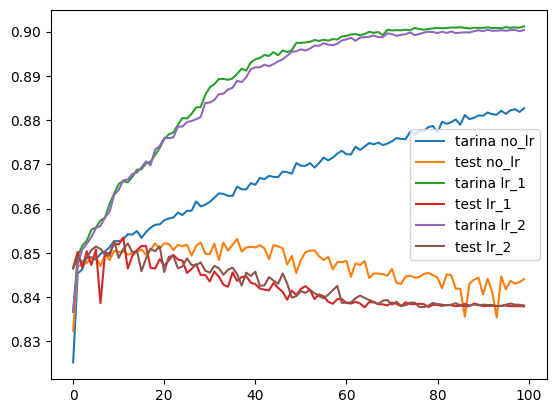

In [15]:
import matplotlib.pyplot as pl
plt.plot(history_adam.history['accuracy'], label = "tarina no_lr")
plt.plot(history_adam.history['val_accuracy'], label = "test no_lr")
plt.plot(history_adam_lr_1.history['accuracy'], label = "tarina lr_1")
plt.plot(history_adam_lr_1.history['val_accuracy'], label = "test lr_1")
plt.plot(history_adam_lr_2.history['accuracy'], label = "tarina lr_2")
plt.plot(history_adam_lr_2.history['val_accuracy'], label = "test lr_2")

plt.legend()
plt.show()